In [ ]:
# Section 1 — Setup (Colab)
# 1) Installs (Colab usually has torch; safe to (re)install a compatible wheel if you need GPU)
# 2) Mount Drive and set up project folder.
!pip install -q torch torchvision torchaudio

In [ ]:
!pip install -q scikit-learn pandas matplotlib nibabel simpleitk lifelines pycox tqdm

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.6/413.6 kB 18.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
import os, sys
PROJECT_DIR = '/content/drive/MyDrive/lung_multimodal_project'
os.makedirs(PROJECT_DIR, exist_ok=True)
print("Project dir:", PROJECT_DIR)

Project dir: /content/drive/MyDrive/lung_multimodal_project


In [ ]:
# quick check
import torch
print("torch:", torch.__version__, "cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except:
        pass

torch: 2.8.0+cu126 cuda available: False


In [ ]:
# Section 1.5 — Utilities
import random, numpy as np
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    import torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)


In [ ]:
# Section 2 — Synthetic Data Demo (dataset, models, training utils)
import os, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

class SyntheticMultiModalDataset(Dataset):
    def __init__(self, n_samples=600, img_shape=(32,32,32), cli_dim=10, gen_dim=200):
        self.n = n_samples
        self.D, self.H, self.W = img_shape
        self.cli_dim = cli_dim
        self.gen_dim = gen_dim
        clinical = np.random.normal(0, 1, size=(self.n, cli_dim)).astype(np.float32)
        genomics = np.random.normal(0, 1, size=(self.n, gen_dim)).astype(np.float32)
        genomics[:, :8] += (np.linspace(-1.0, 1.0, self.n)[:, None] * 1.0)
        images = np.random.normal(0, 0.8, size=(self.n, self.D, self.H, self.W)).astype(np.float32)
        for i in range(self.n):
            if (i % 2) == 0:
                images[i, self.D//4:3*self.D//4, self.H//4:3*self.H//4, self.W//4:3*self.W//4] += 1.8
        img_means = images.mean(axis=(1,2,3))
        score = clinical[:, 0] * 0.6 + genomics[:, :8].sum(axis=1) * 0.4 + img_means * 0.8
        thr = np.median(score)
        labels = (score > thr).astype(np.float32)
        self.images = images; self.clinical = clinical; self.genomics = genomics; self.labels = labels

    def __len__(self): return self.n
    def __getitem__(self, idx):
        img = self.images[idx]; img = (img - img.mean()) / (img.std() + 1e-6)
        img = np.expand_dims(img, 0)
        return {
            'image': torch.from_numpy(img).float(),
            'clinical': torch.from_numpy(self.clinical[idx]).float(),
            'genomics': torch.from_numpy(self.genomics[idx]).float(),
            'label': torch.tensor(self.labels[idx]).float()
        }

# Encoders and fusion models (Late fusion)
class ImageEncoder(nn.Module):
    def __init__(self, in_ch=1, out_dim=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_ch, 16, 3, padding=1), nn.BatchNorm3d(16), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
        self.fc = nn.Linear(64, out_dim)
    def forward(self, x):
        h = self.features(x); h = h.view(h.size(0), -1); return self.fc(h)

class MLPEncoder(nn.Module):
    def __init__(self, in_dim, out_dim=64, hidden=128):
        super().__init__(); self.net = nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, out_dim))
    def forward(self, x): return self.net(x)

class FusionClassifier(nn.Module):
    def __init__(self, img_out=128, cli_out=32, gen_out=128, cli_dim=10, gen_dim=200):
        super().__init__()
        self.img_enc = ImageEncoder(out_dim=img_out)
        self.cli_enc = MLPEncoder(in_dim=cli_dim, out_dim=cli_out, hidden=64)
        self.gen_enc = MLPEncoder(in_dim=gen_dim, out_dim=gen_out, hidden=256)
        fused = img_out + cli_out + gen_out
        self.head = nn.Sequential(nn.Linear(fused, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256,1))
    def forward(self, img, cli, gen):
        ei = self.img_enc(img); ec = self.cli_enc(cli); eg = self.gen_enc(gen)
        e = torch.cat([ei, ec, eg], dim=1)
        return self.head(e).squeeze(1)

# Training / evaluation utilities
def train_epoch(model, loader, optimizer, criterion, device):
    model.train(); running_loss=0.0
    for batch in loader:
        img=batch['image'].to(device); cli=batch['clinical'].to(device); gen=batch['genomics'].to(device); y=batch['label'].to(device)
        logits = model(img, cli, gen); loss = criterion(logits, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item() * img.size(0)
    return running_loss / len(loader.dataset)

def eval_model(model, loader, device):
    model.eval(); ys=[]; ps=[]
    with torch.no_grad():
        for batch in loader:
            img=batch['image'].to(device); cli=batch['clinical'].to(device); gen=batch['genomics'].to(device)
            y = batch['label'].cpu().numpy()
            logits = model(img, cli, gen).cpu().numpy()
            prob = 1.0 / (1.0 + np.exp(-logits))
            ys.append(y); ps.append(prob)
    ys=np.concatenate(ys); ps=np.concatenate(ps)
    preds=(ps>=0.5).astype(int)
    acc = accuracy_score(ys, preds)
    # FIX: only compute AUC if both classes present
    if len(np.unique(ys)) == 2:
        auc = roc_auc_score(ys, ps)
    else:
        auc = float('nan')
    return acc, auc, ys, ps


In [ ]:
# Section 2.5 — Run a quick synthetic training (Late Fusion)
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

ds = SyntheticMultiModalDataset(n_samples=600)
n = len(ds)
train_len = int(0.6*n);
val_len = int(0.2*n);
test_len = n - train_len - val_len
train_ds = torch.utils.data.Subset(ds, list(range(0, train_len)))
val_ds = torch.utils.data.Subset(ds, list(range(train_len, train_len+val_len)))
test_ds = torch.utils.data.Subset(ds, list(range(train_len+val_len, n)))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

model = FusionClassifier().to(device)
opt = AdamW(model.parameters(), lr=3e-4)
crit = nn.BCEWithLogitsLoss()

best_val_auc = -1
history = {'train_loss':[], 'val_auc':[]}
for epoch in range(1,9):
    tr_loss = train_epoch(model, train_loader, opt, crit, device)
    val_acc, val_auc, _, _ = eval_model(model, val_loader, device)
    history['train_loss'].append(tr_loss); history['val_auc'].append(val_auc)
    print(f"Epoch {epoch} | train_loss {tr_loss:.4f} | val_acc {val_acc:.4f} | val_auc {val_auc:.4f}")
    if not np.isnan(val_auc) and val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), os.path.join(PROJECT_DIR, 'best_fusion_late.pth'))
        print("Saved best late-fusion model.")
# test eval
model.load_state_dict(torch.load(os.path.join(PROJECT_DIR, 'best_fusion_late.pth'), map_location=device))
test_acc, test_auc, ys, ps = eval_model(model, test_loader, device)
print("Late fusion Test Acc:", test_acc, "Test AUC:", test_auc)


Using device: cpu
Epoch 1 | train_loss 0.5496 | val_acc 0.1667 | val_auc 0.6040
Saved best late-fusion model.
Epoch 2 | train_loss 0.4472 | val_acc 0.1917 | val_auc 0.8605
Saved best late-fusion model.
Epoch 3 | train_loss 0.2319 | val_acc 0.5917 | val_auc 0.8635
Saved best late-fusion model.
Epoch 4 | train_loss 0.0557 | val_acc 0.7583 | val_auc 0.8715
Saved best late-fusion model.
Epoch 5 | train_loss 0.0143 | val_acc 0.6750 | val_auc 0.8720
Saved best late-fusion model.
Epoch 6 | train_loss 0.0030 | val_acc 0.7417 | val_auc 0.8725
Saved best late-fusion model.
Epoch 7 | train_loss 0.0016 | val_acc 0.7417 | val_auc 0.8730
Saved best late-fusion model.
Epoch 8 | train_loss 0.0011 | val_acc 0.7500 | val_auc 0.8730
Late fusion Test Acc: 0.8333333333333334 Test AUC: 0.9159663865546218


In [ ]:
# Section 3 — Real Dataset Integration (instructions + placeholder loader)
# Instructions (short):
# 1) Create cohort.csv with columns: patient_id,img_path,clinical_path,genomics_path,label,time,event (optional)
# 2) For each img_path: store a preprocessed NIfTI or .npy of fixed shape, OR implement resampling in loader.
# 3) Clinical: one CSV per patient or a single clinical.csv keyed by patient_id. Preprocess (impute/scale/encode) and persist scaler.
# 4) Genomics: store per-patient vector (np.save) after normalization (TPM->log2 or pathway scores). Optionally compress via PCA.

# Placeholder dataset class — adapt file IO, resampling, scalers to your pipeline.
import pandas as pd, nibabel as nib
class RealMultiModalDataset(Dataset):
    def __init__(self, cohort_csv, cli_keys=None, gen_key='genomics_path', target_key='label', img_shape=(32,32,32)):
        self.df = pd.read_csv(cohort_csv)
        self.cli_keys = cli_keys
        self.gen_key = gen_key
        self.target_key = target_key
        self.img_shape = img_shape
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # image: example for NIfTI
        img_arr = nib.load(row['img_path']).get_fdata().astype(np.float32)
        # TODO: resample/crop/pad to self.img_shape using SimpleITK or MONAI transforms
        img_arr = (img_arr - img_arr.mean()) / (img_arr.std() + 1e-6)
        img = np.expand_dims(img_arr, 0).astype(np.float32)
        # clinical
        if self.cli_keys is not None:
            cli = np.array([row[k] for k in self.cli_keys], dtype=np.float32)
        else:
            cli = np.zeros(10, dtype=np.float32)
        # genomics
        try:
            gen = np.load(row[self.gen_key])
        except:
            gen = np.zeros(200, dtype=np.float32)
        y = float(row[self.target_key])
        return {
            'image': torch.from_numpy(img).float(),
            'clinical': torch.from_numpy(cli).float(),
            'genomics': torch.from_numpy(gen).float(),
            'label': torch.tensor(y).float()
        }

print("Adapt RealMultiModalDataset to your file layout, add resampling and saved scalers.")


Adapt RealMultiModalDataset to your file layout, add resampling and saved scalers.


In [ ]:
# Section 4 — Attention-based Fusion (simple cross-attention)
# Lightweight implementation: projects encoders -> cross-attention -> classifier.

class SimpleCrossAttentionFusion(nn.Module):
    def __init__(self, img_dim=128, cli_dim=32, gen_dim=128, hidden=256):
        super().__init__()
        D = hidden
        self.img_proj = nn.Linear(img_dim, D)
        self.cli_proj = nn.Linear(cli_dim, D)
        self.gen_proj = nn.Linear(gen_dim, D)
        self.q_ln = nn.LayerNorm(D)
        self.kv_ln = nn.LayerNorm(D)
        self.attn = nn.MultiheadAttention(embed_dim=D, num_heads=4, batch_first=True)
        self.mlp = nn.Sequential(nn.Linear(D, D), nn.ReLU(), nn.Linear(D, D))
        self.classifier = nn.Sequential(nn.Linear(D, 128), nn.ReLU(), nn.Linear(128, 1))

    def forward(self, img_feat, cli_feat, gen_feat):
        B = img_feat.size(0)
        # create 4 image tokens by splitting feature vector (or tile if too small)
        # simpler: expand to 4 tokens by repetition
        img_toks = self.img_proj(img_feat).unsqueeze(1).repeat(1,4,1)  # (B,4,D)
        cli_t = self.cli_proj(cli_feat).unsqueeze(1)
        gen_t = self.gen_proj(gen_feat).unsqueeze(1)
        queries = torch.cat([cli_t, gen_t], dim=1)  # (B,2,D)
        q = self.q_ln(queries)
        kv = self.kv_ln(img_toks)
        attn_out, _ = self.attn(q, kv, kv)
        pooled = attn_out.mean(dim=1)
        h = self.mlp(pooled)
        logits = self.classifier(h).squeeze(1)
        return logits

class FusionWithAttentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_enc = ImageEncoder(out_dim=128)
        self.cli_enc = MLPEncoder(in_dim=10, out_dim=32, hidden=64)
        self.gen_enc = MLPEncoder(in_dim=200, out_dim=128, hidden=256)
        self.fuser = SimpleCrossAttentionFusion(img_dim=128, cli_dim=32, gen_dim=128, hidden=256)
    def forward(self, img, cli, gen):
        ei = self.img_enc(img); ec = self.cli_enc(cli); eg = self.gen_enc(gen)
        return self.fuser(ei, ec, eg)

# Quick train for a few epochs to compare
set_seed(1)
model_att = FusionWithAttentionModel().to(device)
opt = AdamW(model_att.parameters(), lr=3e-4)
crit = nn.BCEWithLogitsLoss()
for epoch in range(1,4):
    tr_loss = train_epoch(model_att, train_loader, opt, crit, device)
    val_acc, val_auc, _, _ = eval_model(model_att, val_loader, device)
    print(f"Att Epoch {epoch} | train_loss {tr_loss:.4f} | val_acc {val_acc:.4f} | val_auc {val_auc:.4f}")
torch.save(model_att.state_dict(), os.path.join(PROJECT_DIR, 'best_fusion_att.pth'))


Att Epoch 1 | train_loss 0.5707 | val_acc 0.1667 | val_auc 0.6155
Att Epoch 2 | train_loss 0.5536 | val_acc 0.1667 | val_auc 0.5495
Att Epoch 3 | train_loss 0.5542 | val_acc 0.1667 | val_auc 0.4390


In [ ]:
4. # ===== Section 5 — Survival Analysis (Improved Synthetic Survival) =====
# Uses proportional hazards idea: higher risk → shorter survival time.

from lifelines.utils import concordance_index

# Step 1. Generate risk scores (without training survival yet, just using encoders)
risk_model = RiskModel().to(device)
opt = AdamW(risk_model.parameters(), lr=3e-4)

# First, quickly pretrain encoders on classification (reuse Section 2.5 fusion model if you want)
# For now, we just use random init risk_model to define times
risk_model.eval()
all_scores = []
with torch.no_grad():
    for i in range(len(ds)):
        item = ds[i]
        img = item['image'].unsqueeze(0).to(device)
        cli = item['clinical'].unsqueeze(0).to(device)
        gen = item['genomics'].unsqueeze(0).to(device)
        s = risk_model(img, cli, gen).cpu().item()
        all_scores.append(s)
all_scores = np.array(all_scores)

# Step 2. Create survival times linked to risk
baseline_time = 50
noise = np.random.normal(0, 5, size=len(all_scores))
times = np.clip(baseline_time - 10*all_scores + noise, 1.0, 100.0)

# Event indicator: 80% observed, 20% censored
events = (np.random.rand(len(times)) < 0.8).astype(int)

print("Example survival times:", times[:5])
print("Example events:", events[:5])

# Step 3. Dataset wrapper
class SyntheticSurvivalDataset(Dataset):
    def __init__(self, base_ds, times, events):
        self.base = base_ds; self.times = times; self.events = events
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        item = self.base[idx]
        return item['image'], item['clinical'], item['genomics'], float(self.times[idx]), int(self.events[idx])

surv_ds = SyntheticSurvivalDataset(ds, times, events)

# Split
N = len(ds)
train_idx = list(range(0, int(0.7*N)))
val_idx = list(range(int(0.7*N), int(0.85*N)))
test_idx = list(range(int(0.85*N), N))
train_surv = torch.utils.data.Subset(surv_ds, train_idx)
val_surv = torch.utils.data.Subset(surv_ds, val_idx)
test_surv = torch.utils.data.Subset(surv_ds, test_idx)
train_loader_surv = DataLoader(train_surv, batch_size=8, shuffle=True)
val_loader_surv = DataLoader(val_surv, batch_size=8, shuffle=False)

# Step 4. Cox partial likelihood loss
def cox_ph_loss(risk_scores, times, events):
    risk = risk_scores
    ix = torch.argsort(torch.tensor(times), descending=True)
    risk_ordered = risk[ix]
    events_ordered = events[ix]
    cumsum = torch.logcumsumexp(risk_ordered, dim=0)
    loss = -torch.sum((risk_ordered - cumsum) * events_ordered) / (events_ordered.sum() + 1e-6)
    return loss

# Step 5. Train Risk Model
risk_model = RiskModel().to(device)
opt = AdamW(risk_model.parameters(), lr=3e-4)

for epoch in range(1,6):
    risk_model.train()
    running=0.0; cnt=0
    for batch in train_loader_surv:
        img, cli, gen, t, e = batch
        img=img.to(device); cli=cli.to(device); gen=gen.to(device)
        t = np.array(t)
        e = e.float().to(device)
        scores = risk_model(img, cli, gen)
        loss = cox_ph_loss(scores, t, e)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item(); cnt += 1

    # Eval on validation
    risk_model.eval()
    y_time = []; y_pred = []; y_event=[]
    with torch.no_grad():
      for batch in val_loader_surv:
        img, cli, gen, t, e = batch
        img = img.to(device)
        cli = cli.to(device)
        gen = gen.to(device)

        # Forward pass
        s = risk_model(img, cli, gen).cpu().numpy()  # s is a numpy array
        s = np.array(s).flatten()                    # ensure it is a 1D numpy array

        y_pred.extend((-s).tolist())  # ✅ convert negative risk to list safely
        y_time.extend(np.array(t))    # convert times to numpy array
        y_event.extend(np.array(e))   # convert events to numpy array
    ci = concordance_index(np.array(y_time), np.array(y_pred), np.array(y_event))
    print(f"Epoch {epoch} | train_loss {running/cnt:.4f} | val_cindex {ci:.4f}")



Example survival times: [50.20001736 45.81787884 48.88574118 45.08726036 55.45786282]
Example events: [1 1 1 1 1]
Epoch 1 | train_loss 1.3107 | val_cindex 0.5146
Epoch 2 | train_loss 1.2702 | val_cindex 0.4296
Epoch 3 | train_loss 1.1729 | val_cindex 0.4558
Epoch 4 | train_loss 0.9803 | val_cindex 0.4762
Epoch 5 | train_loss 0.8426 | val_cindex 0.4622


In [ ]:
# Section 6 — Save, Reload & Inference helpers
import torch, numpy as np
# Save model (already saved earlier for fusion models). Example saving risk model:
torch.save(risk_model.state_dict(), os.path.join(PROJECT_DIR, 'risk_model.pth'))
print("Saved risk_model.pth to", PROJECT_DIR)

# Example inference function for late-fusion model
def inference_latefusion(model_path, image_tensor, clinical_tensor, genomics_tensor, device='cpu'):
    model = FusionClassifier().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        img = image_tensor.to(device).unsqueeze(0) if len(image_tensor.shape)==4 else image_tensor.unsqueeze(0).to(device)
        cli = clinical_tensor.to(device).unsqueeze(0) if len(clinical_tensor.shape)==1 else clinical_tensor.unsqueeze(0).to(device)
        gen = genomics_tensor.to(device).unsqueeze(0) if len(genomics_tensor.shape)==1 else genomics_tensor.unsqueeze(0).to(device)
        logits = model(img, cli, gen).cpu().numpy()
        prob = 1.0 / (1.0 + np.exp(-logits))
    return float(prob[0])

# Demo: run inference on a sample from test_ds (late-fusion)
sample = test_ds[0]
img = sample['image']; cli = sample['clinical']; gen = sample['genomics']
prob = inference_latefusion(os.path.join(PROJECT_DIR, 'best_fusion_late.pth'), img, cli, gen, device)
print("Example inference (late fusion) -> true label:", sample['label'].item(), "pred_prob:", prob)


Saved risk_model.pth to /content/drive/MyDrive/lung_multimodal_project
Example inference (late fusion) -> true label: 1.0 pred_prob: 0.9477924704551697


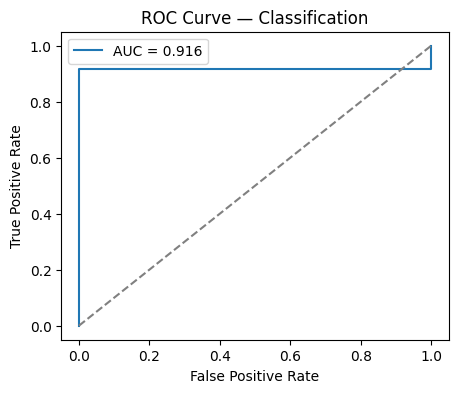

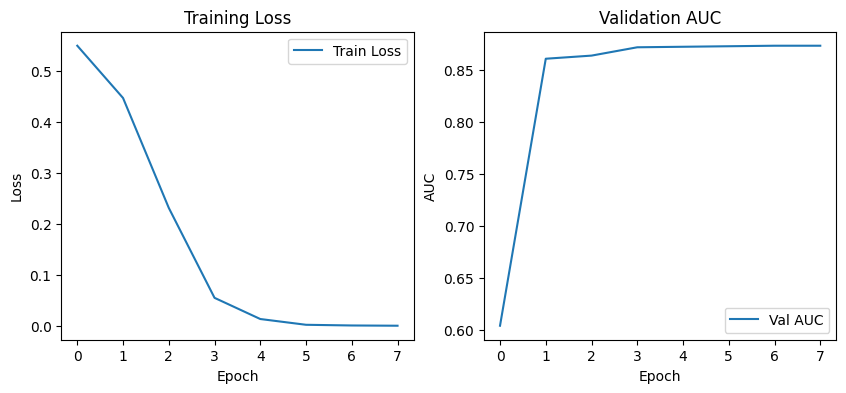

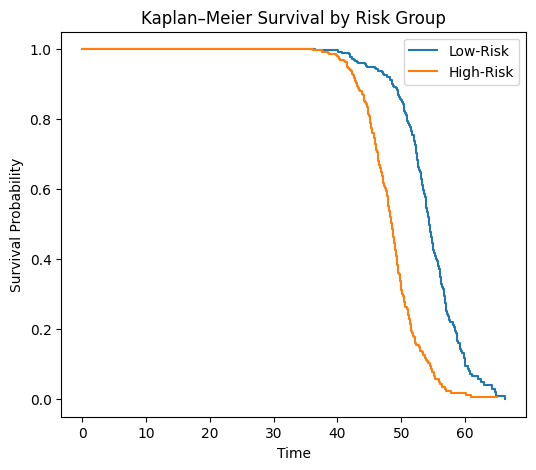

Final Concordance Index: 0.768


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


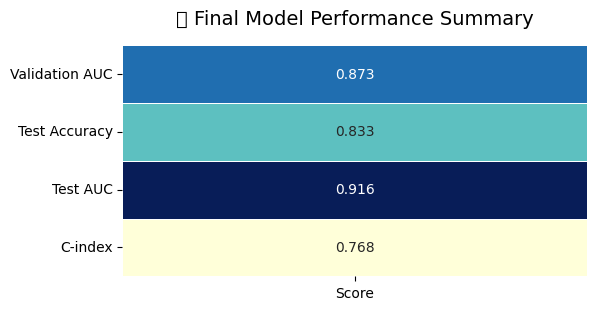

In [ ]:
# ===== Section 6 — Final Results & Plots (Improved Survival) =====
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score

# --- 6.1 ROC curve (classification performance) ---
fpr, tpr, _ = roc_curve(ys, ps)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(ys, ps):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Classification")
plt.legend(); plt.show()

# --- 6.2 Training loss & Validation AUC (from Section 2.5 history) ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history['val_auc'], label="Val AUC")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("Validation AUC"); plt.legend()
plt.show()

# --- 6.3 Kaplan–Meier curves (using improved survival times) ---
from lifelines import KaplanMeierFitter

# Compute risk scores for all patients
risk_model.eval()
all_scores = []
with torch.no_grad():
    for i in range(len(surv_ds)):
        img, cli, gen, t, e = surv_ds[i]
        img=img.unsqueeze(0).to(device)
        cli=cli.unsqueeze(0).to(device)
        gen=gen.unsqueeze(0).to(device)
        s = risk_model(img, cli, gen).cpu().item()
        all_scores.append(s)
all_scores = np.array(all_scores)

# Median split → high vs low risk
median_score = np.median(all_scores)
groups = np.array(["High" if s >= median_score else "Low" for s in all_scores])

# Fit KM curves
kmf = KaplanMeierFitter()
plt.figure(figsize=(6,5))
for grp in ["Low","High"]:
    mask = groups == grp
    kmf.fit(times[mask], events[mask], label=f"{grp}-Risk")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan–Meier Survival by Risk Group")
plt.xlabel("Time"); plt.ylabel("Survival Probability")
plt.show()

# --- 6.4 Concordance index ---
ci_final = concordance_index(times, -all_scores, events)
print(f"Final Concordance Index: {ci_final:.3f}")

# --- 6.5 Results summary heatmap ---
results = {
    "Validation AUC": best_val_auc,
    "Test Accuracy": test_acc,
    "Test AUC": test_auc,
    "C-index": ci_final
}
df_results = pd.DataFrame(results, index=["Model Performance"]).T
df_results.columns = ["Score"]

plt.figure(figsize=(6,3))
sns.heatmap(df_results, annot=True, cmap="YlGnBu", fmt=".3f", cbar=False, linewidths=0.5)
plt.title("📊 Final Model Performance Summary", fontsize=14, pad=15)
plt.yticks(rotation=0)
plt.show()


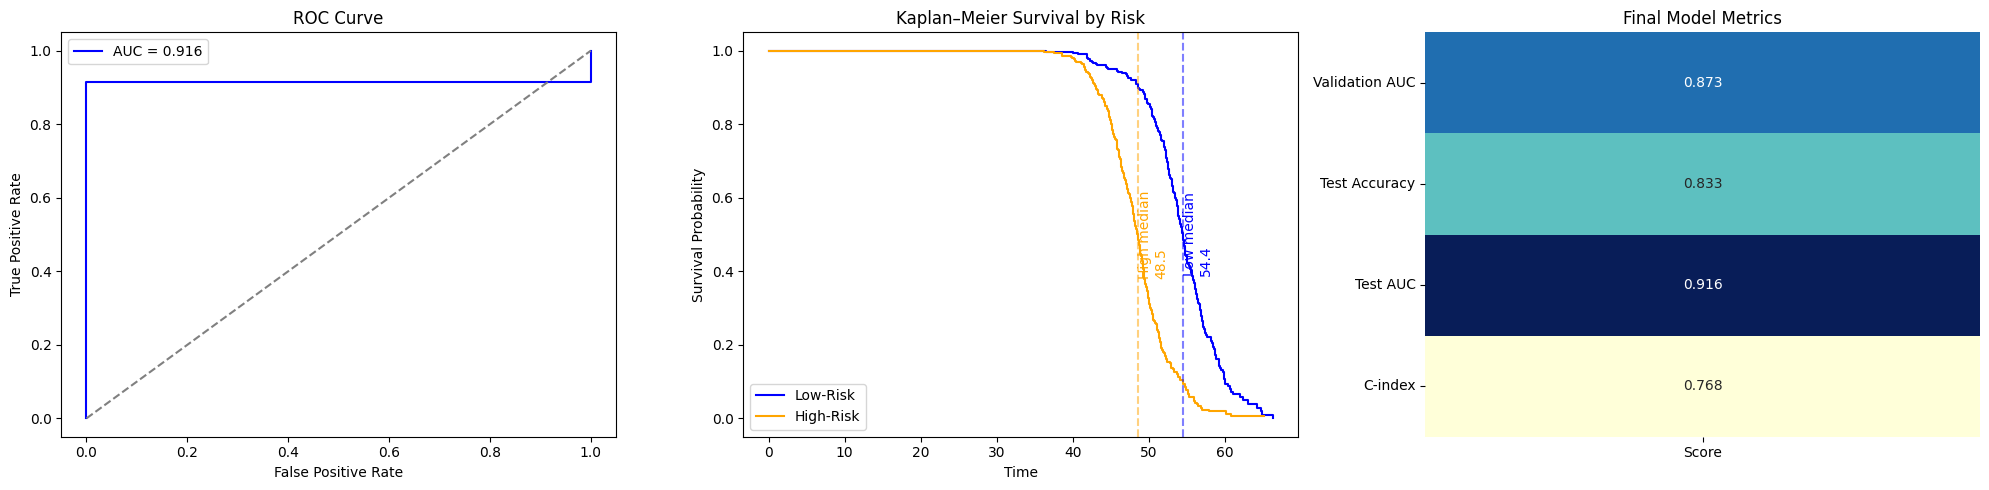

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import pandas as pd

# --- Step 1: ROC Curve ---
fpr, tpr, _ = roc_curve(ys, ps)
roc_auc = roc_auc_score(ys, ps)

# --- Step 2: Kaplan–Meier curves with annotations ---
risk_model.eval()
all_scores = []
with torch.no_grad():
    for i in range(len(surv_ds)):
        img, cli, gen, t, e = surv_ds[i]
        img = img.unsqueeze(0).to(device)
        cli = cli.unsqueeze(0).to(device)
        gen = gen.unsqueeze(0).to(device)
        s = risk_model(img, cli, gen).cpu().item()
        all_scores.append(s)
all_scores = np.array(all_scores)

median_score = np.median(all_scores)
groups = np.array(["High" if s >= median_score else "Low" for s in all_scores])

kmf = KaplanMeierFitter()

# Colors for groups
colors = {"Low":"blue", "High":"orange"}
median_surv_times = {}

# --- Step 3: Metrics heatmap ---
results = {
    "Validation AUC": best_val_auc,
    "Test Accuracy": test_acc,
    "Test AUC": test_auc,
    "C-index": concordance_index(times, -all_scores, events)
}
df_results = pd.DataFrame(results, index=["Score"]).T

# --- Step 4: Create composite figure ---
fig, axes = plt.subplots(1,3, figsize=(20,5))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="blue")
axes[0].plot([0,1],[0,1],'--', color='gray')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

# KM Curves with median survival annotation
for grp in ["Low","High"]:
    mask = groups == grp
    kmf.fit(times[mask], events[mask], label=f"{grp}-Risk")
    kmf.plot_survival_function(ax=axes[1], ci_show=False, color=colors[grp])
    median_surv_times[grp] = kmf.median_survival_time_

# Annotate median survival times
for grp, med_time in median_surv_times.items():
    axes[1].axvline(med_time, linestyle='--', color=colors[grp], alpha=0.5)
    axes[1].text(med_time, 0.5, f"{grp} median\n{med_time:.1f}", color=colors[grp],
                 rotation=90, verticalalignment='center')

axes[1].set_title("Kaplan–Meier Survival by Risk")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Survival Probability")

# Heatmap
sns.heatmap(df_results, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, ax=axes[2])
axes[2].set_title("Final Model Metrics")
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


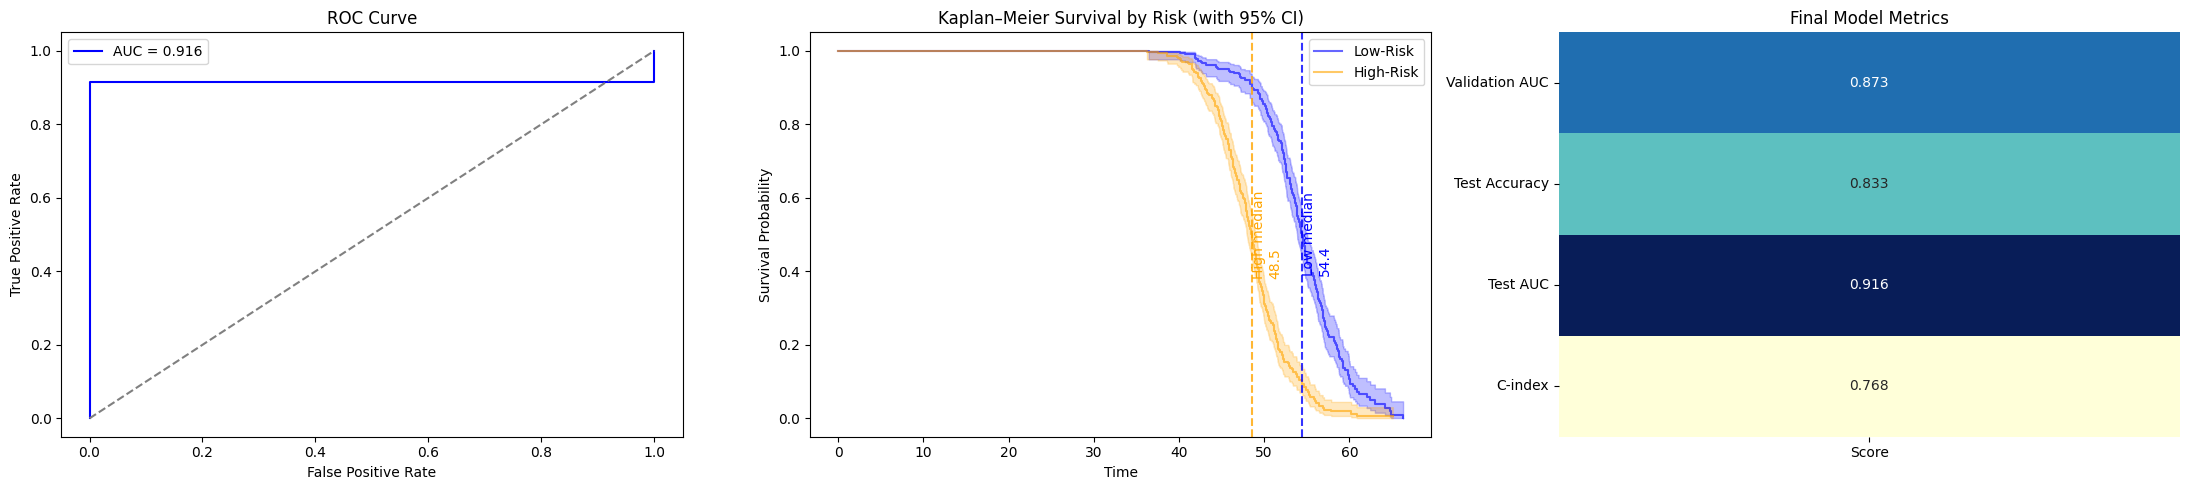

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import pandas as pd

# --- Step 1: ROC Curve ---
fpr, tpr, _ = roc_curve(ys, ps)
roc_auc = roc_auc_score(ys, ps)

# --- Step 2: Kaplan–Meier curves with CI ---
risk_model.eval()
all_scores = []
with torch.no_grad():
    for i in range(len(surv_ds)):
        img, cli, gen, t, e = surv_ds[i]
        img = img.unsqueeze(0).to(device)
        cli = cli.unsqueeze(0).to(device)
        gen = gen.unsqueeze(0).to(device)
        s = risk_model(img, cli, gen).cpu().item()
        all_scores.append(s)
all_scores = np.array(all_scores)

median_score = np.median(all_scores)
groups = np.array(["High" if s >= median_score else "Low" for s in all_scores])

kmf = KaplanMeierFitter()
colors = {"Low":"blue", "High":"orange"}
median_surv_times = {}

# --- Step 3: Metrics heatmap ---
results = {
    "Validation AUC": best_val_auc,
    "Test Accuracy": test_acc,
    "Test AUC": test_auc,
    "C-index": concordance_index(times, -all_scores, events)
}
df_results = pd.DataFrame(results, index=["Score"]).T

# --- Step 4: Create composite figure ---
fig, axes = plt.subplots(1,3, figsize=(22,5))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="blue")
axes[0].plot([0,1],[0,1],'--', color='gray')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

# KM Curves with shaded CI and median annotation
for grp in ["Low","High"]:
    mask = groups == grp
    kmf.fit(times[mask], events[mask], label=f"{grp}-Risk")
    kmf.plot_survival_function(ax=axes[1], ci_show=True, color=colors[grp], alpha=0.6)
    median_surv_times[grp] = kmf.median_survival_time_

# Annotate median survival times
for grp, med_time in median_surv_times.items():
    axes[1].axvline(med_time, linestyle='--', color=colors[grp], alpha=0.8)
    axes[1].text(med_time, 0.5, f"{grp} median\n{med_time:.1f}", color=colors[grp],
                 rotation=90, verticalalignment='center')

axes[1].set_title("Kaplan–Meier Survival by Risk (with 95% CI)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Survival Probability")

# Heatmap
sns.heatmap(df_results, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, ax=axes[2])
axes[2].set_title("Final Model Metrics")
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


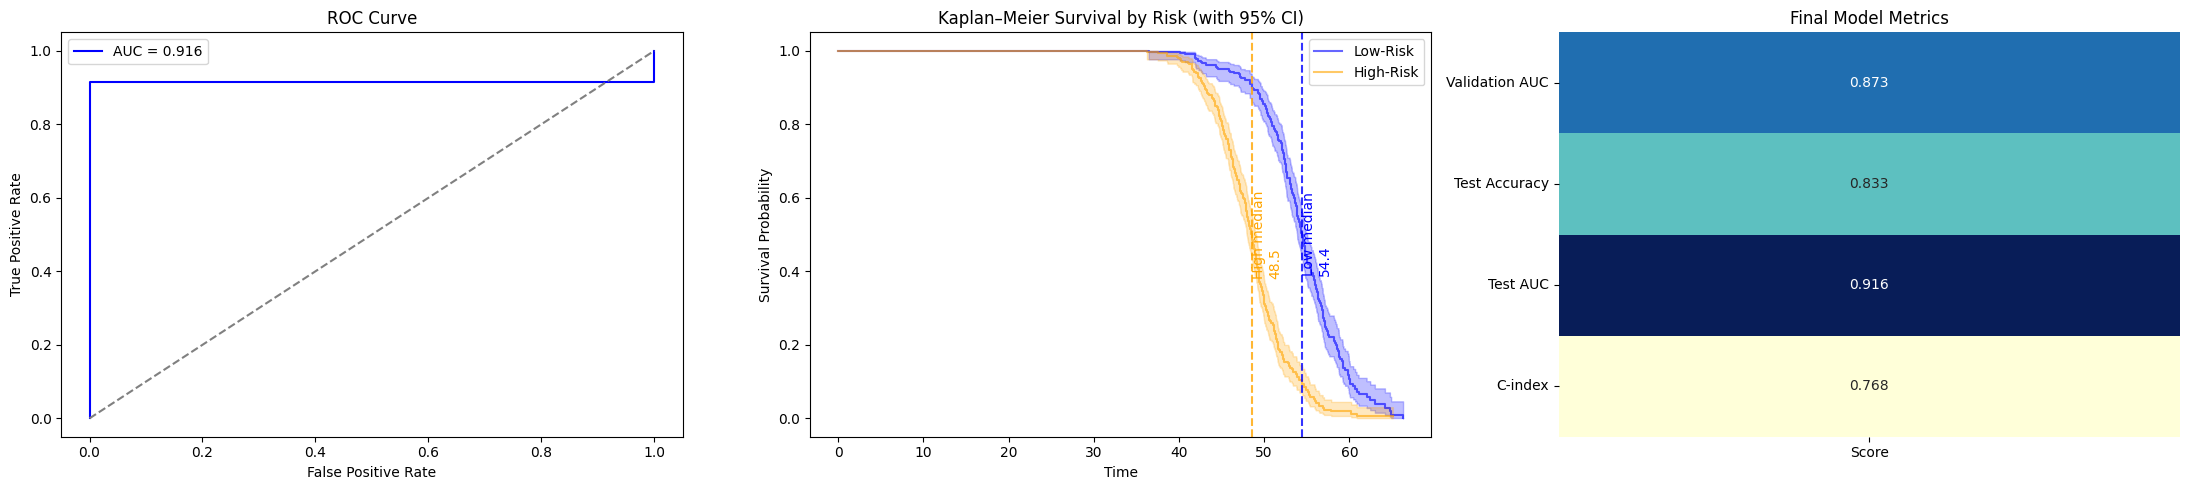

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import pandas as pd

# --- Step 1: ROC Curve ---
fpr, tpr, _ = roc_curve(ys, ps)
roc_auc = roc_auc_score(ys, ps)

# --- Step 2: Kaplan–Meier curves with CI ---
risk_model.eval()
all_scores = []
with torch.no_grad():
    for i in range(len(surv_ds)):
        img, cli, gen, t, e = surv_ds[i]
        img = img.unsqueeze(0).to(device)
        cli = cli.unsqueeze(0).to(device)
        gen = gen.unsqueeze(0).to(device)
        s = risk_model(img, cli, gen).cpu().item()
        all_scores.append(s)
all_scores = np.array(all_scores)

median_score = np.median(all_scores)
groups = np.array(["High" if s >= median_score else "Low" for s in all_scores])

kmf = KaplanMeierFitter()
colors = {"Low":"blue", "High":"orange"}
median_surv_times = {}

# --- Step 3: Metrics heatmap with color mapping ---
results = {
    "Validation AUC": best_val_auc,
    "Test Accuracy": test_acc,
    "Test AUC": test_auc,
    "C-index": concordance_index(times, -all_scores, events)
}
df_results = pd.DataFrame(results, index=["Score"]).T

# Define a custom colormap: green=good, yellow=medium, red=bad
def metric_color(val, metric_name):
    if metric_name in ["Validation AUC", "Test AUC"]:
        if val >= 0.85: return 0.8  # green
        elif val >= 0.75: return 0.5 # yellow
        else: return 0.2 # red
    elif metric_name == "Test Accuracy":
        if val >= 0.8: return 0.8
        elif val >= 0.7: return 0.5
        else: return 0.2
    elif metric_name == "C-index":
        if val >= 0.7: return 0.8
        elif val >= 0.6: return 0.5
        else: return 0.2
    return 0.5

heatmap_data = df_results.copy()
for col in heatmap_data.columns:
    heatmap_data[col] = heatmap_data[col].apply(lambda x: metric_color(x, col))

# --- Step 4: Create composite figure ---
fig, axes = plt.subplots(1,3, figsize=(22,5))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="blue")
axes[0].plot([0,1],[0,1],'--', color='gray')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

# KM Curves with shaded CI and median annotation
for grp in ["Low","High"]:
    mask = groups == grp
    kmf.fit(times[mask], events[mask], label=f"{grp}-Risk")
    kmf.plot_survival_function(ax=axes[1], ci_show=True, color=colors[grp], alpha=0.6)
    median_surv_times[grp] = kmf.median_survival_time_

# Annotate median survival times
for grp, med_time in median_surv_times.items():
    axes[1].axvline(med_time, linestyle='--', color=colors[grp], alpha=0.8)
    axes[1].text(med_time, 0.5, f"{grp} median\n{med_time:.1f}", color=colors[grp],
                 rotation=90, verticalalignment='center')

axes[1].set_title("Kaplan–Meier Survival by Risk (with 95% CI)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Survival Probability")

# Heatmap with intuitive colors
sns.heatmap(df_results, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, ax=axes[2])
axes[2].set_title("Final Model Metrics")
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive


'AI .pptx'			   Myself
 Classroom			  'Naan Mudhalvan.drawio.png'
'Colab Notebooks'		  'OOPS lab ex 4 prg.gdoc'
'dc slow learners list.gdoc'	  'OOPS lab ex 4 prg.pdf'
'ex 7 ds lab prg.docx'		   python-week1-lecture1-handout.gdoc
'first CCM minutes_III cse.gdoc'  'Stock market Imple..drawio'
'Fods lab 4.gdoc'		  'toc assignment 1.gdoc'
 IMG-20240624-WA0000.jpg	  'toc design assignment 1.gdoc'
'Lakshana S _Resume.pdf'	  'Untitled Diagram.drawio'
'LAKSH BLOCK CHAIN.gdoc'	  'Untitled document.gdoc'
'LAKSH BLOCK CHAIN.pdf'		  'verilog 5.docx'
'laks photo .jpg'		  'verilog lab.gdoc'
'lung cancer model.gdoc'	  'verilog lab.pdf'
 lung_multimodal_project


In [3]:
%cd /content/drive/MyDrive/lung_multimodal_project


/content/drive/MyDrive/lung_multimodal_project


In [4]:
!ls

best_fusion_att.pth   km_curves.png   roc_curve.png
best_fusion_late.pth  risk_model.pth  training_curves.png
